### Download Required Data
Link: http://files.grouplens.org/datasets/movielens/ml-100k.zip

### Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

### Read Data Set

In [2]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


### Label Encoding

In [3]:
le = LabelEncoder()
ratings['user_id'] = le.fit_transform(ratings['user_id'])
ratings['item_id'] = le.fit_transform(ratings['item_id'])

### Train Test Split

In [4]:
train_data, test_data = train_test_split(ratings, test_size=0.2)
train_data.head()

,user_id,item_id,rating
41114,200,302,2
15571,279,386,4
79524,823,324,4
8117,12,47,5
51260,697,704,4


In [5]:
num_users = len(train_data.user_id.unique())
num_movies = len(train_data.item_id.unique())
min_rating = train_data['rating'].min()
max_rating = train_data['rating'].max()

print("Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(num_users, num_movies, min_rating, max_rating))

Number of users: 943, Number of Movies: 1645, Min rating: 1, Max rating: 5


# Neural Collaborative Filtering (NCF)
For the loss function there are several options:
- ### MSE (Chosen)
    If you're treating the recommendation problem as a regression task, where the goal is to predict the actual ratings given by users

- ### Categorical Cross-Entropy
    If you're turning the problem into a classification task, where you discretize the ratings into categories or bins
    
- ### Binary Cross-Entropy
    If you're simplifying the problem to binary classification, such as predicting whether a user will like or dislike an item

In [6]:
def create_ncf_model_lightning(num_users, num_items, latent_dim=512, fc_layer_dims=[1024, 512, 128, 64]):
    user_ix = tf.keras.Input(shape=(1,))
    item_ix = tf.keras.Input(shape=(1,))
    
    # Matrix Factorization (MF) Part Components
    user_embedding_layer = layers.Embedding(input_dim=num_users, output_dim=latent_dim)
    item_embedding_layer = layers.Embedding(input_dim=num_items, output_dim=latent_dim)

    # MLP Part Components
    fc_layers = []
    for idx, (in_dim, out_dim) in enumerate(zip(fc_layer_dims[:-1], fc_layer_dims[1:])):
        fc_layers.append(layers.Dense(units=out_dim, activation='relu'))

    # Output Components
    logits = layers.Dense(units=1)

    # MF Part
    user_embedding = user_embedding_layer(user_ix)
    item_embedding = item_embedding_layer(item_ix)
    relevance_product = tf.multiply(user_embedding, item_embedding)

    # MLP Part
    user_item_embs = tf.concat([user_embedding, item_embedding], axis=-1)
    for fc_layer in fc_layers:
        user_item_embs = fc_layer(user_item_embs)

    # Output
    final_latent_rep = tf.concat([user_item_embs, relevance_product], axis=-1)
    output = logits(final_latent_rep)

    model = tf.keras.Model(inputs=[user_ix, item_ix], outputs=output)
    
    return model

In [7]:
num_users = ratings['user_id'].nunique()
num_items = ratings['item_id'].nunique()

model = create_ncf_model_lightning(num_users, num_items, latent_dim=512, fc_layer_dims=[1024, 512, 128, 64])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError())

### Train NCF

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x=[ratings['user_id'], ratings['item_id']], y=ratings['rating'],
                    batch_size=256, epochs=10, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10

313/313 [==============================] - 8s 22ms/step - loss: 1.6250 - val_loss: 0.9356
Epoch 2/10
313/313 [==============================] - 7s 21ms/step - loss: 0.8974 - val_loss: 0.9155
Epoch 3/10
313/313 [==============================] - 6s 19ms/step - loss: 0.8471 - val_loss: 0.9012
Epoch 4/10
313/313 [==============================] - 6s 19ms/step - loss: 0.7764 - val_loss: 0.8899
Epoch 5/10
313/313 [==============================] - 6s 19ms/step - loss: 0.6894 - val_loss: 0.9099
Epoch 6/10
313/313 [==============================] - 6s 19ms/step - loss: 0.5831 - val_loss: 0.9254
Epoch 7/10
313/313 [==============================] - 6s 19ms/step - loss: 0.4800 - val_loss: 0.9530


### Plot Loss History

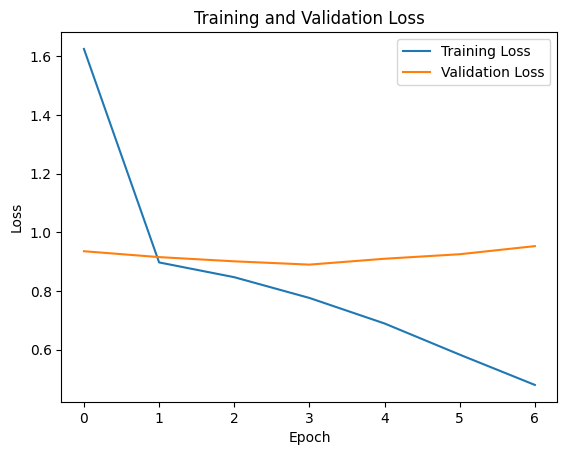

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Recall@10

In [10]:
def precision_recall_at_k(predictions, test_data, k, threshold):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, true_r, est in zip(test_data['user_id'], test_data['rating'], predictions):
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [11]:
predicted_ratings = model.predict([test_data['user_id'], test_data['item_id']])

k = 10
threshold = 4.0

_, recalls = precision_recall_at_k(predicted_ratings, test_data, k, threshold)

avg_recall = sum(recalls.values()) / len(recalls)

print(f'Average Recall@{k}: {avg_recall.squeeze():.4f}')

625/625 [==============================] - 1s 2ms/step
Average Recall@10: 0.3460


### Recommend Top 10 Movies to a Random User

In [12]:
np.random.seed(42)
random_user = np.random.choice(test_data['user_id'].unique())
all_items = np.arange(num_movies)

user_ratings = np.repeat(random_user, num_movies)
item_ratings = all_items
predicted_user_ratings = model.predict([user_ratings, item_ratings])

sorted_indices = np.argsort(predicted_user_ratings.flatten())[::-1]

top_10_movies = le.inverse_transform(sorted_indices[:10])

print("Random User:", random_user)
print("Top 10 Recommended Movies:")
for movie in top_10_movies:
    print(movie)

52/52 [==============================] - 0s 2ms/step
Random User: 79
Top 10 Recommended Movies:
318
1449
64
603
100
272
633
313
187
484
